# Neural Network Embeddings and Visualization using t-SNE

In this notebook, a neural network will be used to create embeddings representations of movies. Each embedding can be seen as a vector representation of a movie in an embedding space. It means that if the embeddings are good enough, similar vectors (movies) will be close in this embedding space. Since in this example, each embedding is a 10-dimentinal vector, t-SNE will be used for dimensional reduction and a better understanding of the results.

## Data preparation for model training

In [1]:
# import libraries

import zipfile
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from sklearn.manifold import TSNE
from urllib.request import urlretrieve

In [2]:
# download movielens dataset

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-25m.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

In [3]:
# extract datasets

NUM_RECORDS = 2000000

ratings = pd.read_csv("/content/ml-25m/ratings.csv")
movies = pd.read_csv("/content/ml-25m/movies.csv")
data = ratings.loc[:,["userId", "movieId", "rating"]]
data = data.iloc[:NUM_RECORDS,:]

In [4]:
# create continuous indexes (needed for the embeddings)

# movieId
uniq = data['movieId'].unique()
movie_index = {movie : idx for idx, movie in enumerate(uniq)}

# userId
uniq = data['userId'].unique()
user_index = {user : idx for idx, user in enumerate(uniq)}

In [5]:
# update dataframe with indexes created

data['movieId'] = np.array([movie_index[x] for x in data['movieId']])
data['userId'] = np.array([user_index[x] for x in data['userId']])

In [6]:
# define variables for the model

ROW_COUNT = data.shape[0]
NUM_USERS = len(user_index)
NUM_MOVIES = len(movie_index)
EMBEDDING_SIZE = 10

## Model definition and training

The inputs for the neural network will be MovieId and UserId and the output will be the rating that the user gave to the movie (this model also can be used to predict that rating that a user could give to a movie that have not seen).

In [7]:
# model definition

def EmbeddingModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
  # movie
  
  movie_input = keras.Input(shape=(1,))
  movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT)(movie_input)
  movie_vec = layers.Flatten()(movie_emb)
  movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)

  # user

  user_input = keras.Input(shape=(1,))
  user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT)(user_input)
  user_vec = layers.Flatten()(user_emb)
  user_model = keras.Model(inputs=user_input, outputs=user_vec)
  
  # concatenation of movie and user embeddings

  merged = layers.Dot(normalize=True, axes=2)([movie_emb, user_emb])
  merged_dropout = layers.Dropout(0.2)(merged)
  dense_1 = layers.Dense(70)(merged)
  dropout_1 = layers.Dropout(0.2)(dense_1)
  dense_2 = layers.Dense(50)(dropout_1)
  dropout_2 = layers.Dropout(0.2)(dense_2)
  dense_3 = keras.layers.Dense(20)(dropout_2)
  dropout_3 = keras.layers.Dropout(0.2)(dense_3)
  dense_4 = keras.layers.Dense(10, activation='relu')(dropout_3)
  result = layers.Dense(1, activation="relu")(dense_4)

  adam = keras.optimizers.Adam(learning_rate=0.001)
  model = keras.Model([movie_input, user_input], result)
  model.compile(optimizer=adam, loss='mean_absolute_error')
  
  return model, movie_model, user_model

model, movie_model, user_model = EmbeddingModel(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In the case, only the training dataset will be used, since we just need the embedding representation of a movie (we do not care about the accuracy of the model).

In [8]:
# model training

history = model.fit([data.movieId, data.userId],
                    data.rating,
                    batch_size=100,
                    epochs=50,
                    verbose=1)

Epoch 1/50
20000/20000 [==============================] - 81s 4ms/step - loss: 0.8499
Epoch 2/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.7712
Epoch 3/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6624
Epoch 4/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6334
Epoch 5/50
20000/20000 [==============================] - 74s 4ms/step - loss: 0.6167
Epoch 6/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6051
Epoch 7/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.5963
Epoch 8/50
20000/20000 [==============================] - 83s 4ms/step - loss: 0.5868
Epoch 9/50
20000/20000 [==============================] - 75s 4ms/step - loss: 0.5794
Epoch 10/50
20000/20000 [==============================] - 74s 4ms/step - loss: 0.5740
Epoch 11/50
20000/20000 [==============================] - 73s 4ms/step - loss: 0.5698
Epoch 12/50
20000/20000 [===========================

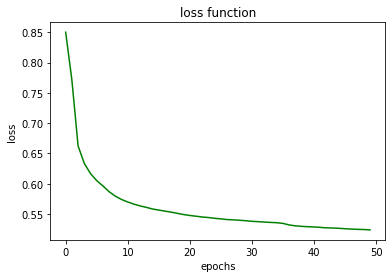

In [9]:
# loss function

plt.plot(history.history['loss'] , 'g')
plt.title('loss function')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

We can observe that the loss value decreases with each epoch. It gives us a good insight of the embeddings.

In [10]:
# save models

model.save('model.h5')
movie_model.save('movie_model.h5')
user_model.save('user_model.h5')

In [11]:
# load movie_model

#movie_model = keras.models.load_model('movie_model.h5')

## Preparing movie dataset for analysis

In [12]:
# movies that were used for training

ratings = ratings.iloc[:NUM_RECORDS,:]
uniq = ratings['movieId'].unique()
movies = movies.loc[movies['movieId'].isin(uniq)].reset_index(drop=True)

# add numberRatings column to movies dataframe

numberRatings = ratings.groupby('movieId').size()
for i in range(len(movies)):
  id = movies.loc[i, 'movieId']
  movies.at[i, 'numberRatings'] = numberRatings[id]

# update dataframe with indexes created for the embedding

movies['movieId'] = np.array([movie_index[x] for x in movies['movieId']])

In [13]:
# there are movies that have few ratings, it can cause some misunderstanding of the embeddings
# that is why a threshold is applied in this step

THRESHOLD = 100
movies_aux = movies[movies.numberRatings >= THRESHOLD].reset_index(drop=True)
print("Went from {} to {} movies after applying threshold".format(len(movies), len(movies_aux)))

movies = movies_aux

Went from 27321 to 3304 movies after applying threshold


## Movies embeddings

In [14]:
# extract movies embeddings from the model

movie_weights = movie_model.get_weights()[0]

# embeddings of movies filtered before

movie_enbeddings = movie_weights[movies['movieId']]

## t-SNE

In [82]:
# t-SNE invocation with movie embeddings

tsne = TSNE(perplexity=40, n_iter=5000, metric="cosine")
embeddings = tsne.fit_transform(movie_enbeddings)

# add t-SNE results to movie dataframe

movies['x'] = embeddings[:, 0]
movies['y'] = embeddings[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [83]:
# function for plotting

def plot_embeddings(embeddings, alpha=0.2):
  fig, ax = plt.subplots(figsize=(13, 9))
  X = embeddings[:, 0]
  Y = embeddings[:, 1]
  ax.scatter(X, Y, alpha=alpha)
  return ax

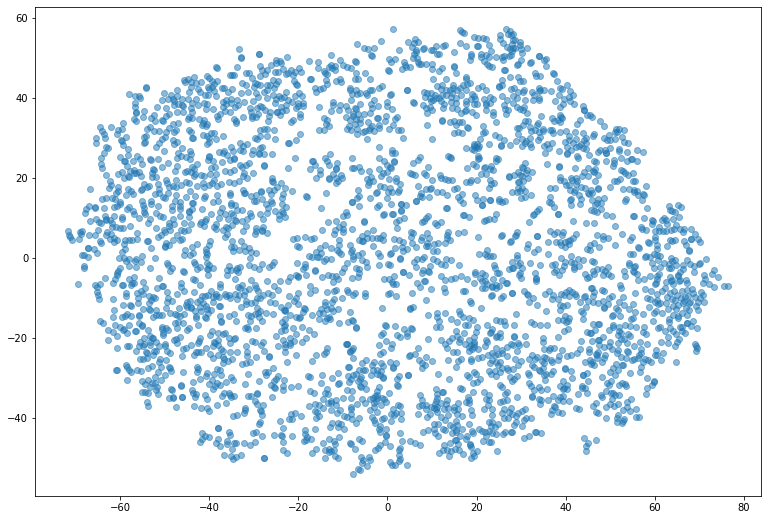

In [84]:
# plot t-SNE results

plot_embeddings(embeddings, 0.5)
plt.show()

This plot is difficult to interpret. So, we are going to use some specific movies and genres to see how they are distributed in the plot.

In [18]:
# functions for plotting

try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

def plot_with_annotations(movies, embeddings, with_title=True, alpha=1):
  ax = plot_embeddings(embeddings, .05)
  X = movies['x']
  Y = movies['y']
  ax.scatter(X, Y, alpha=alpha, color='green')
  
  if with_title:
    titles = movies['title'].values
    texts = []
    for label, x, y in zip(titles, X, Y):
      t = ax.annotate(label, xy=(x, y))
      texts.append(t)
      adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
  
  return ax

def plot_by_title_pattern(movies, embeddings, pattern, with_title=False):
  movies_aux = movies[movies.title.str.contains(pattern)]
  return plot_with_annotations(movies_aux, embeddings, with_title)

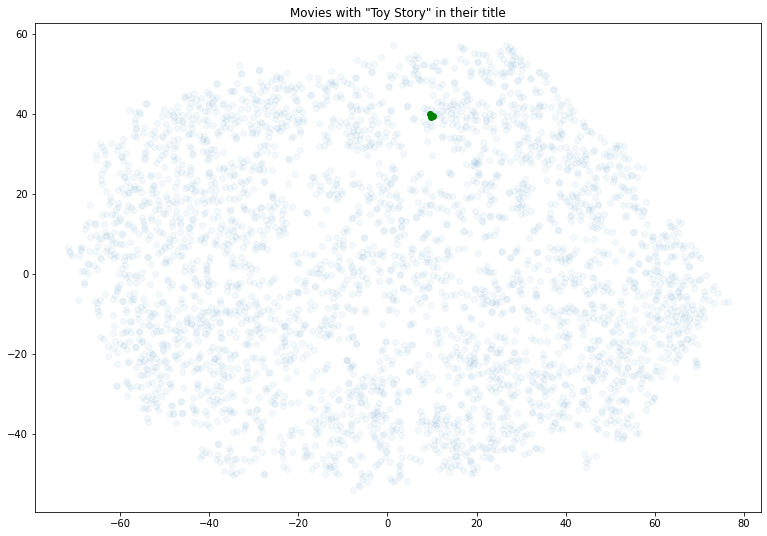

In [111]:
# plot movies by title pattern

plot_by_title_pattern(movies, embeddings, 'Toy Story')
plt.title('Movies with "Toy Story" in their title')
plt.show()

The green dots are movies that have "Toy Story" in their title. We can observe how they are close to each other (they have a similar embedding representation).

In [20]:
# functions for plotting

def plot_region(movies, x0, x1, y0, y1, text=True):
  fig, ax = plt.subplots(figsize=(13, 9))
  pts = movies[(movies.x >= x0) & (movies.x <= x1) & (movies.y >= y0) & (movies.y <= y1)]
  ax.scatter(pts.x, pts.y, alpha=.6)
  ax.set_xlim(x0, x1)
  ax.set_ylim(y0, y1)
  
  if text:
    texts = []
    for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
      t = ax.annotate(label, xy=(x, y))
      texts.append(t)
      adjust_text(texts, expand_text=(1.01, 1.05))

  return ax

def plot_region_around(movies, title, margin=5):
  xmargin = ymargin = margin
  movie_aux = movies[movies.title == title]
  assert len(movie_aux) == 1
  row = movie_aux.iloc[0]
  return plot_region(movies, row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin)

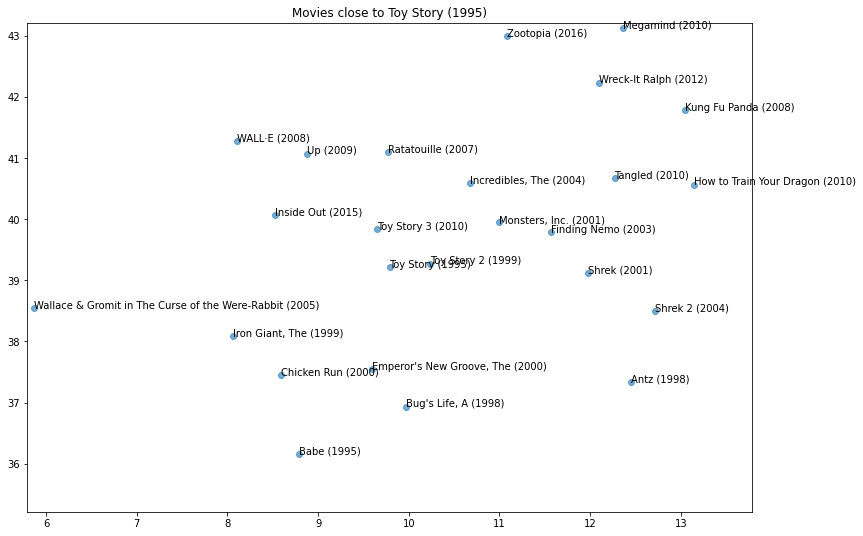

In [113]:
# plot movies around a specific movie

plot_region_around(movies, 'Toy Story (1995)', 4)
plt.title('Movies close to Toy Story (1995)')
plt.show()

This plot shows us the movie's embeddings close to "Toy Story (1995)". As we can see not only the movies with tittle "Toy Story" are close, but other movies similar to them like: Monsters Inc, Ratatouille, Finding Nemo, etc.

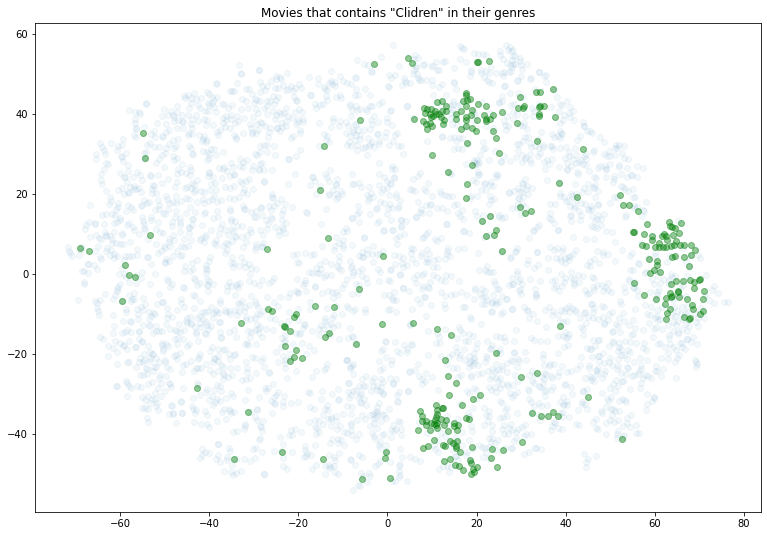

In [115]:
# plot movies with a genre

movies_genres = movies[movies.genres.str.contains('Children')]
plot_with_annotations(movies_genres, embeddings, with_title=False, alpha=.4)
plt.title('Movies that contain "Clidren" in their genres')
plt.show()

In this case, the green dots show us the movies that contain "Children" in the genres. We can observe how three clusters have been defined. We need to take into account that a movie has more than a genre, i.e. Children|Adventure, Children|Comedy, etc. That is why we have more than a cluster.

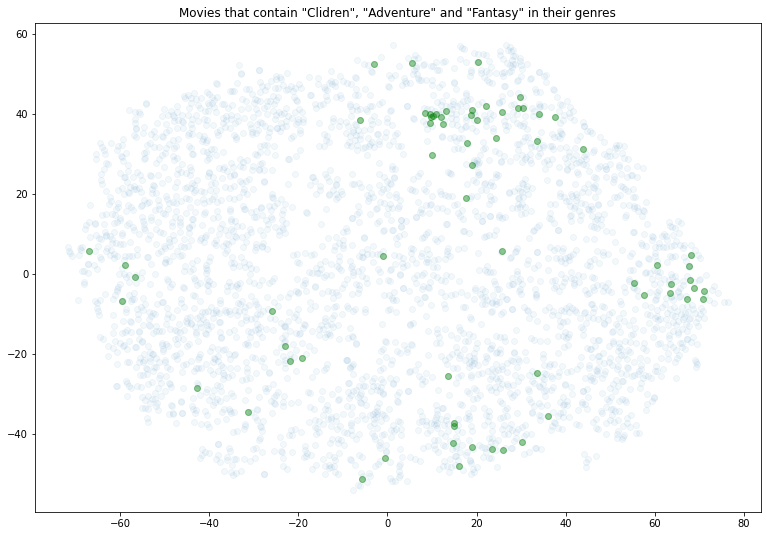

In [116]:
# plot movies with different genres

movies_genres = movies[(movies.genres.str.contains('Children')) & (movies.genres.str.contains('Adventure')) & (movies.genres.str.contains('Fantasy'))]
plot_with_annotations(movies_genres, embeddings, with_title=False, alpha=.4)
plt.title('Movies that contain "Clidren", "Adventure" and "Fantasy" in their genres')
plt.show()

In this plot, more genres have been taken into account for the movies, so we can observe one main cluster in the upper-right side.

## References


*   https://www.kaggle.com/code/willkoehrsen/neural-network-embedding-recommendation-system/notebook#Visualizations
*   https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278
*   https://distill.pub/2016/misread-tsne/
*   https://www.kaggle.com/code/colinmorris/visualizing-embeddings-with-t-sne/notebook

